In [3]:
import os, re
import warnings 
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
warnings.filterwarnings(action='ignore')

# 1. Data load

## 1.1 Init setting variables

> 프로젝트에서 주로 사용할 변수를 초기에 설정하는 작업을 진행한다.

In [4]:
# 1. 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 2. X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 3. 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 4. model setting
BATCH_SIZE = 16
EPOCHS = 25

## 1.2 Pneumonia data load

> 위 파일 경로 변수를 활용하여 의학용 데이터를 로드한다.

In [5]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


> 불러온 데이터를 확인한 결과 아래와 같은 정보를 획득했다.<br>
> 1. 훈련용 데이터는 5216개 이다.<br>
> 2. 검증용 데이터는 16개이다.<br>
> 3. 테스트용 데이터는 624개이다.

# 2. Data preprocessing

## 2.1 훈련용, 검증용 데이터 재분배

> 목록 1.2에서 검증용 데이터의 표본이 너무 적어 검증역할을 잘 수행할지 염려된다.<br>
> 때문에, 표본이 가장 풍부한 train 데이터 셋의 일부를 검증용 데이터로 활용하는 작업을 진행하고자 한다.<br>
> 훈련용 데이터와 검증용 데이터 세트를 병합 후, 훈련용 데이터를 80%, 검증용 데이터를 20% 비율로 재 분배하는 과정을 진행한다.

In [6]:
# step1. train 데이터와 validation 데이터 병합
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# step2. (train):(val) 8:2비율로 재 분배
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

# step3. 결과 확인
print(len(train_filenames))
print(len(val_filenames))

4185
1047


> 위 작업을 통해 다음과 같이 데이터가 가공되었다.<br>
> 1. 훈련용 데이터는 4185개 이다. (가공 전 : 5216개)<br>
> 2. 검증용 데이터는 1047개 이다. (가공 전 : 16개)<br>

> 해당 작업으로 충분한 검증용 데이터를 확보했다.<br>
> 위 데이터를 활용하여 사전에 mini-batch를 설정한다.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

> 이후, 훈련용 데이터 세트에서 정상과 폐렴 데이터의 비율을 확인하는 작업을 진행한다.

In [8]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"훈련용 데이터에서 정상 이미지 개수 : {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"훈련용 데이터에서 폐렴 이미지 개수 : {COUNT_PNEUMONIA}")

훈련용 데이터에서 정상 이미지 개수 : 1070
훈련용 데이터에서 폐렴 이미지 개수 : 3115


> 위 확인 작업으로, 다음과 같은 정보를 얻었다.<br>
> 1. 훈련용 데이터에 정상 사진은 1070개 이다.<br>
> 2. 훈련용 데이터에 정상 사진은 3115개 이다.<br>
> 3. 정상과 폐렴 데이터의 비율은 약 1:3이다.

## 2.2 Labeling

> 현재 데이터에는 해당 이미지가 어떤 데이터인지 명시되어 있지 않다.<br>
> 위 문제를 해결하기 위해 각 데이터에 라벨을 생성하는 함수를 구현했다.

In [9]:
# 폐렴이면 양성(True), 노말이면 음성(False)을 반환하는 함수
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"

> 이미지 데이터의 규격를 일원화하여 오류 방지 및 학습 효율을 증대하는 함수를 구현했다.

In [10]:
def decode_img(img):
    # step1. 이미지 형식을 uint8 tensor로 변경
    img = tf.image.decode_jpeg(img, channels=3)
    
    # step2. float32 형식으로 변경
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # step3. 이미지 크기 변경 (180, 180)
    img = tf.image.resize(img, IMAGE_SIZE)
    
    return img

> 라벨 작업과 이미지 변경 작업을 일원화 하여 편의성을 얻기위한 함수를 구현했다.

In [11]:
# 이미지 파일의 경로 입력 시, 이미지와 라벨 데이터를 반환하는 함수
def process_path(file_path):
    
    # step1. get label
    label = get_label(file_path)
    
    # step2. load image
    img = tf.io.read_file(file_path)
    
    # step3. image convert
    img = decode_img(img)
    
    return img, label

> process_path()함수를 활용하여 훈련용 데이터와 검증용 데이터를 전처리한다.

## 2.3 Create dataset

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


> 전처리 후, 임의의 훈련용 데이터를 확인해본 결과 이미지 크기 변환 및 라벨이 잘 생성되었음을 확인할 수 있다.<br>
> 테스트용 데이터도 위와 동일한 전처리를 진행한다.

In [14]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


## 2.4 Set data pipeline

> tf.data의 파이프라인을 이용하여 학습 데이터를 효율적으로 사용할 수 있도록 prepare_for_training() 함수를 구현한다<br>
> 이후, 학습용 데이터와 검증용 데이터에 파이프라인 설정을 진행한다.

In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    
    # step1. 버퍼의 크기 설정 후 데이터 섞기
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    
    # step2. 데이터셋 사용 반복
    ds = ds.repeat()
    
    # step3. 배치 크기 설정
    ds = ds.batch(BATCH_SIZE)
    
    # step4. 학습 데이터 대기열 설정
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 2.5 Data visualization check

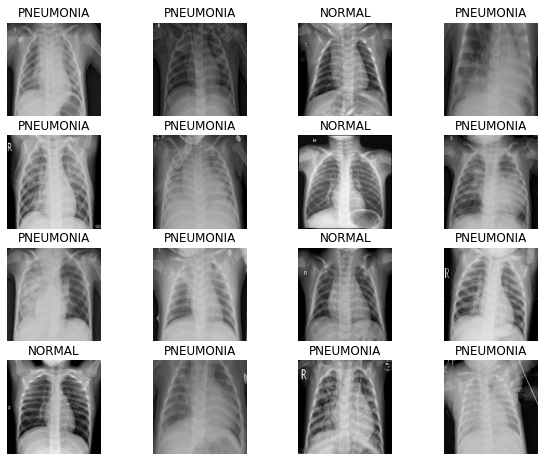

In [16]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 3. CNN Modeling

> Conv 단계에서 깊이 분석 이미지 처리에 강점을 보이는 SeparableConv2D모델을 활용하여 Conv layer를 구성했다.

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

> Dense 단계에는 오버 피팅을 방지하기 위하여 일정 노드를 비활성화 하는 드롭 아웃 레이어를 추가했다.

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

>  LMS의 코드는 가뜩이나 학습에 사용될 데이터도 적은데 드롭 아웃의 비율도 너무 높아, 드롭 아웃 비율을 낮추어 재설정했다.

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.5),
        dense_block(128, 0.2),
        dense_block(64, 0.1),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 4. Data imbalance processing

> 학습용과 검증용 데이터간 비율의 불균형 문제를 해결하기 위해, 각 데이터 비율로 나눈 class_weight를 설정하는 작업을 진행했다.

In [30]:
weight_for_0 = (1 / COUNT_NORMAL)*(len(train_filenames))/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(len(train_filenames))/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


# 5. Model train

> 학습용 데이터가 적어, 모델에 early stopping 기능을 추가했다.

In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS)

In [22]:
with tf.device('/GPU:0'):
    es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
    
    history = model.fit(
        train_ds,
        steps_per_epoch=len(train_filenames) // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=len(val_filenames) // BATCH_SIZE,
        callbacks=[es],
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 90s 234ms/step - loss: 0.3885 - accuracy: 0.8029 - precision: 0.9514 - recall: 0.7750 - val_loss: 0.7297 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 58s 224ms/step - loss: 0.1859 - accuracy: 0.9291 - precision: 0.9785 - recall: 0.9242 - val_loss: 1.5264 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 59s 227ms/step - loss: 0.1631 - accuracy: 0.9348 - precision: 0.9790 - recall: 0.9328 - val_loss: 0.2453 - val_accuracy: 0.8827 - val_precision: 0.8623 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 59s 228ms/step - loss: 0.1533 - accuracy: 0.9487 - precision: 0.9831 - recall: 0.9472 - val_loss: 0.2817 - val_accuracy: 0.8798 - val_precision: 1.0000 - val_recall: 0.8357
Epoch 5/25
261/261 [==============================] - 60s 231ms/step - loss: 0.1315 - accura

# 6. result

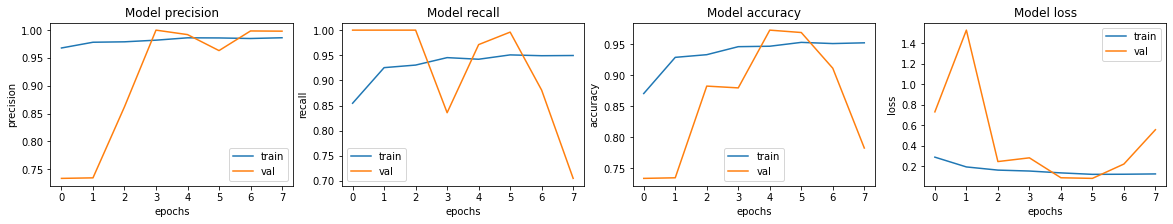

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 144ms/step - loss: 0.4011 - accuracy: 0.8574 - precision: 0.9337 - recall: 0.8308
Loss: 0.40106794238090515,
Accuracy: 0.8573718070983887,
Precision: 0.9337176084518433,
Recall: 0.8307692408561707


> 결과를 시각화한 그래프를 보았을때, epoch 5가 가장 적절했음을 그래프에서 확인 할 수 있다.<br>
> early stopping기능에 의해 epoch 7인 모델로도 정확도가 85.7%를 보여주었다.<br>
> 만약 epoch 5인 모델이였다면 recall과 accuracy, loss의 성능이 더 좋은 결과를 보여주었을것 같다.

# 7. augmentation기법을 활용한 모델 훈련

> augmentation기법을 활용하여 기존 이미지를 변환했을때 모델의 학습 결과를 확인하는 과정을 진행한다.<br>
> 이를 위하여, 이미지의 좌우를 반전하는 함수를 구현하고, 데이터 전처리 및 모델 훈련을 진행한다.

## 7.1 Augmentation 함수 구현

In [33]:
def augmentation_LR(image,label):
    image = tf.image.random_flip_left_right(image)
    return image,label

## 7.2 훈련&검증용 데이터 준비

In [34]:
def prepare_for_training_v2(ds, shuffle_buffer_size=1000):
    
    # step1. augmentation 기법 적용
    ds = ds.map(augmentation_LR, num_parallel_calls=2)
    
    # step2. 버퍼의 크기 설정 후 데이터 섞기
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    
    # step3. 데이터셋 사용 반복
    ds = ds.repeat()
    
    # step4. 배치 크기 설정
    ds = ds.batch(BATCH_SIZE)
    
    # step5. 학습 데이터 대기열 설정
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

In [35]:
agument_train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
agument_val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [36]:
agument_train_ds = prepare_for_training(agument_train_ds)
agument_val_ds = prepare_for_training(agument_val_ds)

> augmentation을 활용하여 기존 이미지가 좌우반전된 이미지를 확보했다.

## 7.3 모델 훈련

In [37]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS)

In [38]:
with tf.device('/GPU:0'):
    es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
    
    history = model.fit(
        agument_train_ds,
        steps_per_epoch=len(train_filenames) // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=agument_val_ds,
        validation_steps=len(val_filenames) // BATCH_SIZE,
        callbacks=[es],
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 84s 228ms/step - loss: 0.3835 - accuracy: 0.8181 - precision: 0.9569 - recall: 0.7873 - val_loss: 0.6732 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 58s 224ms/step - loss: 0.2042 - accuracy: 0.9300 - precision: 0.9764 - recall: 0.9286 - val_loss: 1.4940 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 58s 224ms/step - loss: 0.1671 - accuracy: 0.9396 - precision: 0.9797 - recall: 0.9383 - val_loss: 0.4132 - val_accuracy: 0.8298 - val_precision: 0.8117 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 59s 227ms/step - loss: 0.1330 - accuracy: 0.9473 - precision: 0.9849 - recall: 0.9445 - val_loss: 0.1585 - val_accuracy: 0.9385 - val_precision: 0.9236 - val_recall: 0.9987
Epoch 5/25
261/261 [==============================] - 59s 228ms/step - loss: 0.1299 - accura

## 7.4 결과 확인

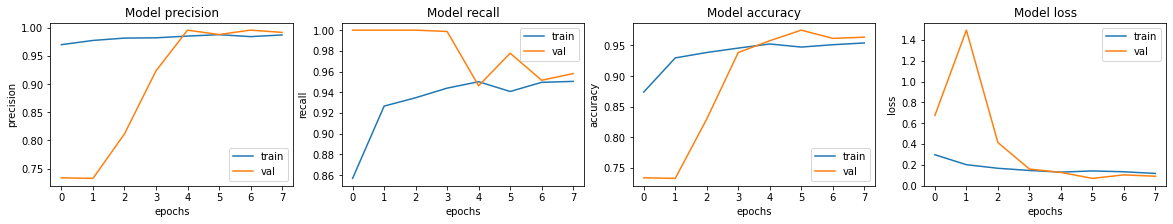

In [39]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [42]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 144ms/step - loss: 0.6462 - accuracy: 0.8478 - precision: 0.8132 - recall: 0.9821
Loss: 0.6461522579193115,
Accuracy: 0.8477563858032227,
Precision: 0.8131634593009949,
Recall: 0.9820512533187866


> 결과를 시각화한 그래프를 보았을때, 안정적으로 그래프가 수렴했음을 확인 할 수 있다.<br>
> early stopping기능에 의해 epoch 7에서 훈련이 멈추었으며,정확도는 84.7%를 보여주었다.<br>
> 기존 이미지 모델에 비해 accracy가 1% 감소, Loss 0.2 증가, precision 0.12감소 라는 나쁜 결과를 보여주었다.<br>
> 그러나, Racall 항목은 기존 모델에 비해 0.15가 증가한 긍정적인 결과를 보여주었다.

# 후기

> 의료 관련 모델에서는 실제 환자를 판독하는것이 가장 중요하다고 생각합니다.<br>
> 그렇기에, accracy는 비교적 낮을지라도 racall이 높은 augmentation 모델이 폐렴 검출에 더 적합하다고 생각합니다.